## Using LSTM model to predict rice prices in NCR

Multivariate

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_excel('final_data_research.xlsx')

In [5]:
df.columns

Index(['Date', 'Rice Price (PHP)', 'Temperature in (°C)', 'Precipitation (mm)',
       'Fuel Price (Regular Gasoline)', ' Soil Moisture (cm)',
       'Soil Temperature (°C)', 'Exchange Rate', 'Rice Import Policy'],
      dtype='object')

In [6]:
# assiging the x and y variables

X = df[['Temperature in (°C)', 'Precipitation (mm)', 'Fuel Price (Regular Gasoline)', ' Soil Moisture (cm)', 'Soil Temperature (°C)', 'Exchange Rate', 'Rice Import Policy']]
y = df['Rice Price (PHP)']

## Preprocessing Data

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5369, 7), (2301, 7), (5369,), (2301,))

In [10]:
# scaling the data and transforming from 2d to 3d

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [11]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

## Creating the LSTM Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
cp1 = ModelCheckpoint('model1/.keras', save_best_only=True)
model1.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [38]:
model1.fit(X_train_scaled, y_train_scaled, validation_data=(X_test_scaled, y_test_scaled), epochs=10, callbacks=[cp1])

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

In [42]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/.keras')

In [44]:
train_predictions_scaled = model1.predict(X_train_scaled)
test_predictions_scaled = model1.predict(X_test_scaled)

# Reverse the scaling for the predictions
train_predictions = scaler_y.inverse_transform(train_predictions_scaled).flatten()
test_predictions = scaler_y.inverse_transform(test_predictions_scaled).flatten()

# Compare the predictions with the actual values
print("Training Data:")
print(pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train}))

print("\nTesting Data:")
print(pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals': y_test}))

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training Data:
      Train Predictions  Actuals
3455          31.513590    30.00
3855          31.562080    30.00
4438          29.505354    30.00
5650          34.178925    36.83
2629          26.201071    26.80
...                 ...      ...
5226          33.018177    36.99
5390          34.477612    35.72
860           19.454834    18.98
7603          38.415668    38.46
7270          37.662922    37.77

[5369 rows x 2 columns]

Testing Data:
      Test Predictions  Actuals
2031         20.086185    21.44
4246         30.768518    30.00
5969         37.006767    36.81
5662         31.862034    36.08
1730         21.348907    21.36
...                ...      ...
5825         37.789078    35.97
4391         30.218788    30.00
3505         31.189268    30.00
947          18.426022    18.72
2835         34.302391    30.00

[2301 rows x 2 columns]


In [53]:
train_actuals = np.array(y_train)
test_actuals = np.array(y_test)

### Training Data - Actuals vs Predicted

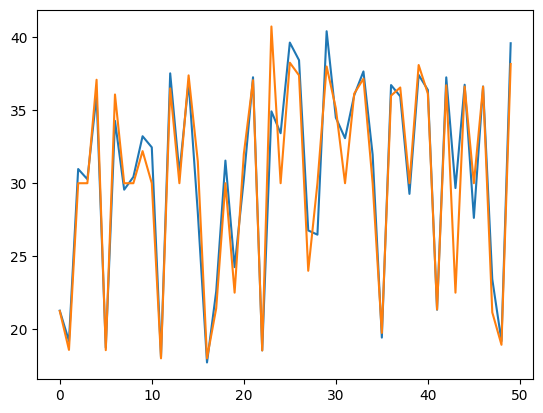

In [57]:
import matplotlib.pyplot as plt

plt.plot(train_predictions[50:100])
plt.plot(train_actuals[50:100])

### Validation Data - Actuals vs Predicted

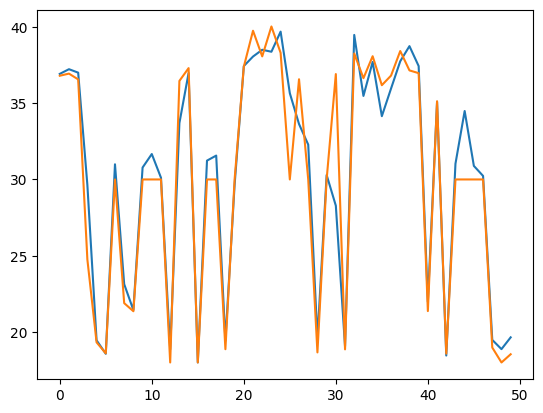

In [61]:
plt.plot(test_predictions[50:100])
plt.plot(test_actuals[50:100])